In [1]:
# Re-run after kernel reset to test full pipeline

import pandas as pd
import numpy as np
import torch
import random
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from scipy.stats import norm

# --- Set Seed ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# --- Data Preparation ---
def prepare_data(device, path, n_samples=400, test_size=0.2, recal_size=0.2, batch_size=32, seed=5):
    set_seed(seed)
    data = pd.read_excel(path).sample(n=n_samples, random_state=seed)
    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2:].values
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train, X_recal, y_train, y_recal = train_test_split(X_temp, y_temp, test_size=recal_size / (1 - test_size), random_state=seed)
    X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
    X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()
    mean_X, std_X = X_train.mean(0), X_train.std(0)
    mean_y, std_y = y_train.mean(0), y_train.std(0)
    X_train = (X_train - mean_X) / std_X
    X_test = (X_test - mean_X) / std_X
    y_train = (y_train - mean_y) / std_y
    y_test = (y_test - mean_y) / std_y
    return (
        X_train.to(device), y_train.to(device), 
        DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True),
        X_test.to(device), y_test.to(device),
        mean_X, std_X, mean_y, std_y
    )

# --- Model ---
class MultiOutputMCDropout(nn.Module):
    def __init__(self, input_size, n_hidden=32, dropout_p=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(input_size, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc_mean = nn.Linear(n_hidden, 2)
        self.fc_cov = nn.Linear(n_hidden, 3)

    def forward(self, x):
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        mean = self.fc_mean(self.dropout(x))
        cov_params = self.fc_cov(self.dropout(x))
        log_var = cov_params[:, :2]
        rho = 0.99 * torch.tanh(cov_params[:, 2])
        std = torch.exp(0.5 * log_var)
        cov12 = rho * std[:, 0] * std[:, 1]
        cov = torch.zeros(x.size(0), 2, 2, device=x.device)
        cov[:, 0, 0] = std[:, 0]**2
        cov[:, 1, 1] = std[:, 1]**2
        cov[:, 0, 1] = cov12
        cov[:, 1, 0] = cov12
        return mean, cov

# --- Loss ---
def multi_output_nll(mean, cov, y):
    eps = 1e-3
    eye = torch.eye(2, device=mean.device).unsqueeze(0)
    dist = torch.distributions.MultivariateNormal(mean, cov + eps * eye)
    return -dist.log_prob(y).mean()

# --- Train ---
def train(model, optimizer, train_loader, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            mean, cov = model(xb)
            loss = multi_output_nll(mean, cov, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.3f}")

# --- MC Prediction ---
def mc_predict(model, X, n_samples=10):
    model.train()
    means, covs = [], []
    with torch.no_grad():
        for _ in range(n_samples):
            m, c = model(X)
            means.append(m.cpu().numpy())
            covs.append(c.cpu().numpy())
    return np.stack(means), np.stack(covs)

# --- Predictive Stats ---
def compute_tau(p=0.9, l=1.0, N=400, wd=1e-5):
    return (p * l**2) / (2 * N * wd)

def predictive_stats_with_tau(mc_means, mc_covs, tau):
    mean = mc_means.mean(axis=0)
    epi_cov = np.einsum('tni,tnj->nij', mc_means, mc_means) / mc_means.shape[0] - np.einsum('ni,nj->nij', mean, mean)
    ale_cov = mc_covs.mean(axis=0)
    total_cov = ale_cov + epi_cov + np.eye(2) * (1 / tau)
    return mean, np.array([np.diag(c) for c in total_cov]), total_cov

def compute_picp(y_true, pred_mean, total_var, confidence=0.8):
    z = norm.ppf((1 + confidence) / 2)
    lower = pred_mean - z * np.sqrt(total_var)
    upper = pred_mean + z * np.sqrt(total_var)
    picp = np.mean((y_true >= lower) & (y_true <= upper), axis=0) * 100
    return lower, upper, picp

# Execute
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = "synthetic_data.xlsx"
X_train, y_train, train_loader, X_test, y_test, mean_X, std_X, mean_y, std_y = prepare_data(device, path)

model = MultiOutputMCDropout(input_size=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
train(model, optimizer, train_loader, device)

mc_means, mc_covs = mc_predict(model, X_test)
tau = compute_tau(N=len(X_train))
pred_mean, total_diag, _ = predictive_stats_with_tau(mc_means, mc_covs, tau)
y_test_np = y_test.cpu().numpy()
_, _, picp = compute_picp(y_test_np, pred_mean, total_diag)

picp_output = {"PICP@80% Measured": round(picp[0], 2), "PICP@80% Predicted": round(picp[1], 2)}
picp_output


Epoch 1, Loss: 20.202
Epoch 2, Loss: 16.415
Epoch 3, Loss: 15.076
Epoch 4, Loss: 13.367
Epoch 5, Loss: 12.201


{'PICP@80% Measured': 97.5, 'PICP@80% Predicted': 98.75}

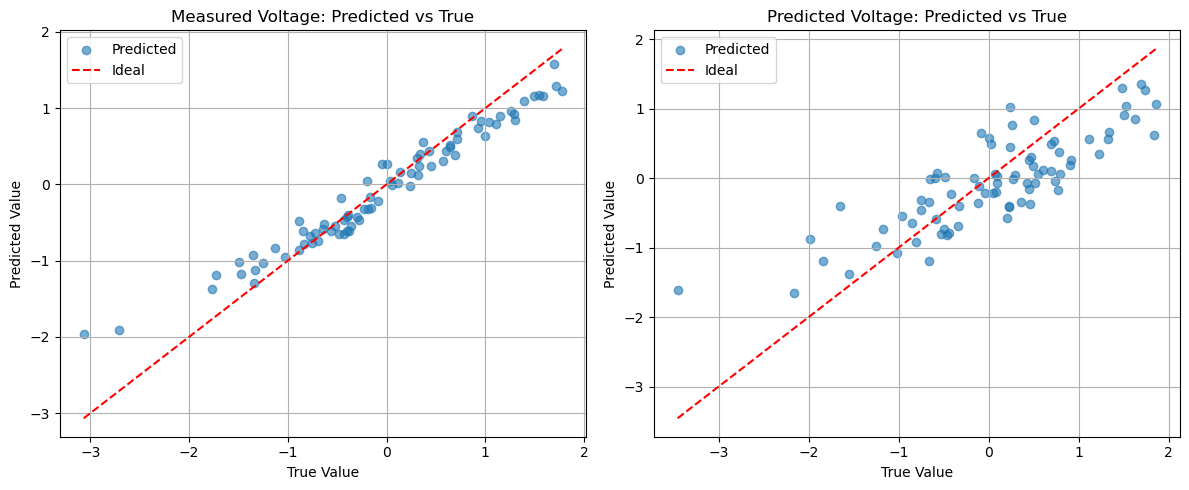

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot 1: Predicted vs True for both targets
def plot_predictions_vs_true(y_true, pred_mean, target_names=["Measured Voltage", "Predicted Voltage"]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(2):
        axs[i].scatter(y_true[:, i], pred_mean[:, i], alpha=0.6, label='Predicted')
        axs[i].plot([y_true[:, i].min(), y_true[:, i].max()],
                    [y_true[:, i].min(), y_true[:, i].max()],
                    'r--', label='Ideal')
        axs[i].set_title(f"{target_names[i]}: Predicted vs True")
        axs[i].set_xlabel("True Value")
        axs[i].set_ylabel("Predicted Value")
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

# Plot 2: PICP curve
def plot_picp_curve(y_true, pred_mean, total_var, target_names=["Measured Voltage", "Predicted Voltage"], levels=np.linspace(0.5, 0.99, 20)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(2):
        empirical_coverage = []
        z_values = norm.ppf((1 + levels) / 2)
        for z in z_values:
            lower = pred_mean[:, i] - z * np.sqrt(total_var[:, i])
            upper = pred_mean[:, i] + z * np.sqrt(total_var[:, i])
            coverage = np.mean((y_true[:, i] >= lower) & (y_true[:, i] <= upper))
            empirical_coverage.append(coverage)
        axs[i].plot(levels, empirical_coverage, marker='o', label='Observed')
        axs[i].plot(levels, levels, 'r--', label='Ideal')
        axs[i].set_title(f"{target_names[i]}: PICP vs CI")
        axs[i].set_xlabel("Confidence Interval")
        axs[i].set_ylabel("Empirical Coverage")
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()
    

plot_predictions_vs_true(y_test_np, pred_mean)
plot_picp_curve(y_test_np, pred_mean, total_diag)

